# This repo is an implmentation of PCA as an autoencoder in PyTorch
![mathematical equation.JPG](<attachment:mathematical equation.JPG>)
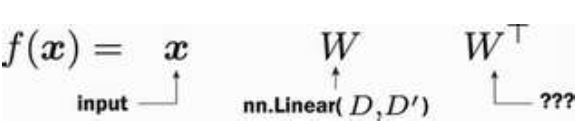

In [31]:
import torch
from torch import nn
import torch.nn.functional as F
from utils import View
from utils import train_network
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms

ImportError: cannot import name 'train_network' from 'utils' (d:\projects\git-hub\PCA-as-autoencoders-implmentation_in_PyTorch\utils.py)

In [5]:
D=28*28               # Dimension of the input data
n=2                   # no of hidden layers
C=1                   # no of channels
classes=10            # output classes

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class TransposeLinear(nn.Module):
    def __init__(self,linearlayer,bias=True):
        '''
        This function takes a linear layer and
        transposes it through weight sharing techniques 
        bias term = True means we will create a new bias for the transposed layer
        '''
        super().__init__()
        self.weight = linearlayer.weight

        if bias:
            self.bias = nn.Parameter(torch.Tensor(linearlayer.weight.shape[1]))
        else:
            self.register_parameter('bias',None)


    def forward(self,x:torch.Tensor):
        return F.linear(x,self.weight.t(),self.bias)

In [9]:
#Since we will share the weights of the linear layer, lets define it separately
linearLayer = nn.Linear(D,  n, bias=False)
#The encoder just falltens and then uses the linear layer
PCA_encoder = nn.Sequential(
    nn.Flatten(),
    linearLayer,
)
#The decoder uses our TransposeLinear layer + the now shared linearLayer object 
PCA_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28, 28)#Shape the data back to it's original form [View function is imported from utils.py]
)

In [10]:
#Define a final PCA model that is the sequence of an encoder, followed by a decoder
PCA_model = nn.Sequential(
    PCA_encoder,
    PCA_decoder
)

### We have everything we need to train up this autoencoder. 
But to make it truly PCA, we need to add
the W*W⊤ = I constraint.
 This constraint has a name: orthogonality.

In [14]:
torch.manual_seed(42)
nn.init.orthogonal_(linearLayer.weight)

Parameter containing:
tensor([[ 0.0688,  0.0531,  0.0322,  ...,  0.0275, -0.0274, -0.0339],
        [ 0.0017,  0.0038,  0.0273,  ...,  0.0153, -0.0002, -0.0210]],
       requires_grad=True)

In [16]:
mse_loss = nn.MSELoss() #Original loss function

def mseWithOrthoLoss(x, y):#our PCA loss function
    #Grabing W from the linearLayer object we saved earlier. 
    W = linearLayer.weight
    #The identity matrix that is the target for the regularized
    I = torch.eye(W.shape[0]).to(device)
    #compute the original loss $\ell_{\mathit{MSE}}(f(\boldsymbol{x}), \boldsymbol{x})$
    normal_loss =  mse_loss(x, y) 
    #compute the regularizer penalty $\ell_{\mathit{MSE}}(W^\top W, \boldsymbol{I})$
    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
    #return the sum of the two losses
    return normal_loss + regularization_loss

In [19]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label. 

In [ ]:
train_data = AutoEncodeDataset(MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [30]:
train_network(PCA_model, mseWithOrthoLoss, train_loader, test_loader=test_loader, epochs=10, device=device)

NameError: name 'train_network' is not defined